In [ ]:
# pre solve data in /MocapRecog/SkeletalData


import natsort
import os

dir_loc = "./MocapRecog/SkeletalData"
all_bvh = os.listdir(dir_loc)
bvh_paths = natsort.natsorted(all_bvh)

for bvh_path in bvh_paths:
  if os.path.splitext(bvh_path)[-1][1:] != "bvh":
    continue

  os.system("bvh-converter ./MocapRecog/SkeletalData/" + bvh_path)

In [ ]:
# get world pos by from csv

import numpy
import natsort
import os
import pandas as pd
import math
import matplotlib.pyplot as plt

def fillByRepeat(array, maxNum):
  if len(array) > maxNum:
    return array[:maxNum]

  tempArray = []
  for i in range(math.ceil(maxNum / len(array))):
    tempArray.extend(array)

  return tempArray[:maxNum]

def writeDisDataFrame(pd_reader, path, maxFrame):
  disData = {"pelvisDis" : [], "leftHandDis" : [], "rightHandDis" : [], "twoHandDis" : []}

  for index in range(len(pd_reader['Time'])):
    lhPos = [pd_reader['LeftHand.X'][index], pd_reader['LeftHand.Y'][index], pd_reader['LeftHand.Z'][index]]
    rhPos = [pd_reader['RightHand.X'][index], pd_reader['RightHand.Y'][index], pd_reader['RightHand.Z'][index]]
  
    pelvisDis = pd_reader['Hips.Y'][index]
    leftHandDis = pd_reader['LeftHand.Y'][index]
    rightHandDis = pd_reader['RightHand.Y'][index]
    twoHandDis = numpy.sqrt(numpy.square(lhPos[0] - rhPos[0]) + numpy.square(lhPos[1] - rhPos[1]) + numpy.square(lhPos[1] - rhPos[1]))
  
    disData["pelvisDis"].append(pelvisDis)
    disData["leftHandDis"].append(leftHandDis)
    disData["rightHandDis"].append(rightHandDis)
    disData["twoHandDis"].append(twoHandDis)

  disData["pelvisDis"] = fillByRepeat(disData["pelvisDis"], maxFrame)
  disData["leftHandDis"] = fillByRepeat(disData["leftHandDis"], maxFrame)
  disData["rightHandDis"] = fillByRepeat(disData["rightHandDis"], maxFrame)
  disData["twoHandDis"] = fillByRepeat(disData["twoHandDis"], maxFrame)

  df = pd.DataFrame(disData)
  df.to_csv("./MocapRecog/DisData/" + path)

bvh_loc = "./MocapRecog/SkeletalData"
all_bvh = os.listdir(bvh_loc)
bvh_paths = natsort.natsorted(all_bvh)

# base on the max frame of the dataset
maxFrame = 128 * 128

finalData = []
for bvh_path in bvh_paths:
  if os.path.splitext(bvh_path)[-1][1:] != "csv":
    continue

  pd_reader = pd.read_csv("./MocapRecog/SkeletalData/" + bvh_path)
  finalData.append(writeDisDataFrame(pd_reader, bvh_path, maxFrame))

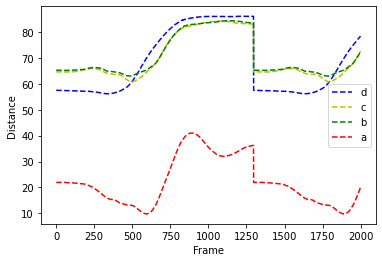

In [ ]:
# look at the line graph
import matplotlib.pyplot as plt
import pandas as pd
maxFrame = 128 * 128
def lineGraph(disData):
  x = range(2000)
  plt.plot(x, disData["pelvisDis"][:2000], ls='--', color='b', label='d')
  plt.plot(x, disData["leftHandDis"][:2000], ls='--', color='y', label='c')
  plt.plot(x, disData["rightHandDis"][:2000], ls='--', color='g', label='b')
  plt.plot(x, disData["twoHandDis"][:2000], ls='--', color='r', label='a')
  plt.xlabel("Frame")
  plt.ylabel("Distance")
  plt.legend()
  plt.show()

pd_reader = pd.read_csv("./MocapRecog/DisData/" + "skl_s01_a11_r01_worldpos.csv")
lineGraph(pd_reader)

In [ ]:
# data loader


import os
import pandas as pd
import natsort
import torch
from torch import tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

import math

def getWH(num):
  width = math.ceil(math.sqrt(num))

  for i in range(num):
    if num % width == 0:
      break
    
    width = width + 1
  return width, int(num / width)

def solveData(path):
  pd_reader = pd.read_csv(path)
  curDis = []

  width = 128
  height = 128

  hArr0 = []
  hArr1 = []
  hArr2 = []
  hArr3 = []
  for h in range(height):
    wArr0 = []
    wArr1 = []
    wArr2 = []
    wArr3 = []
    for w in range(width):
      wArr0.append(pd_reader['pelvisDis'][h * width + w])
      wArr1.append(pd_reader['leftHandDis'][h * width + w])
      wArr2.append(pd_reader['rightHandDis'][h * width + w])
      wArr3.append(pd_reader['twoHandDis'][h * width + w])

    hArr0.append(wArr0)
    hArr1.append(wArr1)
    hArr2.append(wArr2)
    hArr3.append(wArr3)
        
  curDis.append(hArr0)
  curDis.append(hArr1)
  curDis.append(hArr2)
  curDis.append(hArr3)

  return curDis

class LoadFromFolder(Dataset):
    def __init__(self, main_dir):
      self.all_dis = os.listdir(main_dir)
      self.dis_paths = natsort.natsorted(self.all_dis)
      self.pre_symbol = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
      self.label2Id = {'01' : 0, '02' : 1, '03' : 2, '04' : 3, '05' : 4, '06' : 5, '07' : 6, '08' : 7, '09' : 8, '10' : 9, '11' : 10, '12' : 11}

      self.data = []
      for dis_path in self.dis_paths:
        self.data.append(solveData(main_dir + dis_path))

      self.symbols = []
      for dis_path in self.dis_paths:
        for sym in self.pre_symbol:
          if 'a' + sym in dis_path:
            self.symbols.append(sym)
            break

          if "t" in dis_path:
            self.symbols.append('12')
            break

      self.len = len(self.dis_paths)

    def __len__(self):
      return self.len

    def __getitem__(self, idx):
      return torch.Tensor(self.data[idx]), self.label2Id[self.symbols[idx]]

In [ ]:
dataset = LoadFromFolder(main_dir = "./MocapRecog/DisData/")
torch.save(dataset, './MocapRecog/DataSet/dataset.pkl')

In [ ]:
# load data loader

import os
import pandas as pd
import natsort
import torch
from torch import tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

dataset = torch.load('./MocapRecog/DataSet/dataset.pkl')

In [ ]:
# dataloader init

dataloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

In [ ]:
# data set test
# print(dataset.__getitem__(0))
batch = next(iter(dataloader))
x, y = batch
print("Distance Array:")
print(x.shape)
print()
print("Label:")
print(y.shape)
print(y)

Distance Array:
torch.Size([5, 4, 128, 128])

Label:
torch.Size([5])
tensor([ 4, 10,  4,  4, 10])


In [ ]:
# CNN model

import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
          nn.Conv2d(4, 64, 5, 1, 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(64, 192, 5, 1, 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(192, 384, 3, 1, 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(384, 256, 3, 1, 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
          nn.Linear(20736, 5),
          nn.ReLU(),
          nn.Linear(5, 5),
          nn.ReLU(),
          nn.Linear(5, 13))

    def forward(self, x):
      x = self.features(x)
      x = x.view(x.size()[0],-1)
      output = self.classifier(x)
      return output

In [ ]:
from torch import device
from torch import cuda
from torch.optim import Adam
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

dataloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

print(torch.cuda.is_available())
print(torch.cuda.device_count())

device = torch.device("cuda")

cnn = CNN()
cnn = cnn.to(device)

optimizer = Adam(cnn.parameters(), lr=0.001)

batch = next(iter(dataloader))
x, y = batch
x = x.to(device)
y = y.to(device)
print()
print(x.shape)
print(y.shape)

loss_func = nn.CrossEntropyLoss()

output = cnn(x)
output.to(device)
print(y)
loss = loss_func(output, y)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print('loss1:', loss.item())

output = cnn(x)
output = output.to(device)
loss = loss_func(output, y)
loss = loss.to(device)
print('loss2:', loss.item())

True
1
tensor([11,  1,  4, 10,  3], device='cuda:0')
loss1: 2.6640450954437256
loss2: 2.6263880729675293


In [ ]:
train_losses = []
valid_losses = []

train_loader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)
valid_loader = DataLoader(dataset=dataset, batch_size=5, shuffle=False)

for epoch in range(200):
  train_loss = 0.0
  valid_loss = 0.0
  num = 0
  for step, batch in enumerate(train_loader):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    output = cnn(x)
    output = output.to(device)
    loss = loss_func(output, y)

    optimizer.zero_grad()
    
    loss = loss.to(device)
    loss.backward()
    
    optimizer.step()
    train_loss += loss.item()
    num+=1

    output.cpu()
    x.cpu()
    y.cpu()

  train_loss /= num

  num = 0
  for step, batch in enumerate(valid_loader):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    output = cnn(x)
    output = output.to(device)
    loss = loss_func(output, y)

    valid_loss += loss.item()
    num+=1

    output.cpu()
    x.cpu()
    y.cpu()

  
  valid_loss /= num

  print('epoch:',epoch,' | train loss:',train_loss,' | valid loss',valid_loss)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

Text(0.5, 1.0, 'CNN')

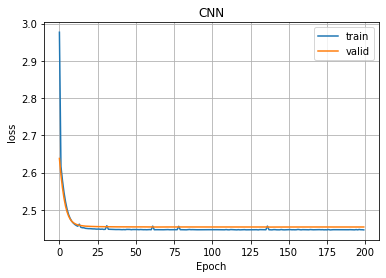

In [ ]:
# training loss graph
import matplotlib.pyplot as plt
plt.subplot(1, 1, 1)
val_line, = plt.plot(train_losses, label='train')
train_line, = plt.plot(valid_losses, label='valid')
plt.legend(handles=[val_line, train_line])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.title("CNN")

In [ ]:
torch.save(cnn, "./MocapRecog/Model/CNN.pkl")

In [ ]:
# predict
import os
import pandas as pd
import natsort
import torch
from torch import tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

cnn = torch.load("./MocapRecog/Model/CNN.pkl")

In [ ]:
import numpy as np
input = solveData("./MocapRecog/DisData/" + "skl_s01_a04_r05_worldpos.csv")
cnn.eval()
output = cnn(torch.Tensor(input).unsqueeze(0).to(device))
print(output.data)
a = nn.functional.softmax(output.cpu()).detach().numpy()[0]
predicted = np.argmax(a)
print(predicted)

tensor([[-15.2971,   0.0447,   0.0481,   0.0338,   0.0371,   0.0568,   0.0393,
           0.0561,   0.0179,   0.0384,   0.0364,   0.0533,  -1.5639]],
       device='cuda:0')
5


C:\Users\23002\AppData\Local\Temp/ipykernel_11008/3011312619.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = nn.functional.softmax(output.cpu()).detach().numpy()[0]


In [ ]:
test_loader = DataLoader(dataset=dataset, batch_size=5, shuffle=False)

def confusion_matrix(preds, labels, conf_matrix):
  preds = torch.argmax(preds, 1)
  for p, t in zip(preds, labels):
    conf_matrix[p, t] += 1
  return conf_matrix

conf_matrix = torch.zeros(12, 12)
with torch.no_grad():
  for step, batch in enumerate(test_loader):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    out = cnn(x)

    conf_matrix = confusion_matrix(out, y, conf_matrix)
    conf_matrix = conf_matrix.cpu()

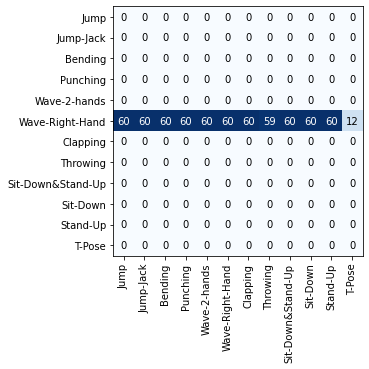

In [ ]:
import matplotlib.pyplot as plt

Emotion=12
labels = ['Jump', 'Jump-Jack', 'Bending', 'Punching', 'Wave-2-hands', 'Wave-Right-Hand', 'Clapping', 'Throwing', 'Sit-Down&Stand-Up', 'Sit-Down', 'Stand-Up', 'T-Pose']
 
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
 
thresh = conf_matrix.max() / 2
for x in range(12):
    for y in range(12):
        info = int(conf_matrix[y, x])
        plt.text(x, y, info,
                 verticalalignment='center',
                 horizontalalignment='center',
                 color="white" if info > thresh else "black")
                  
plt.tight_layout()
plt.yticks(range(12), labels)
plt.xticks(range(12), labels,rotation=90)
plt.show()
plt.close()